# Bank Notes Anomaly Detection 

---
## Objective
This analysis focuses on authenticating banknotes using machine learning techniques. The dataset contains features extracted from images of genuine and forged banknotes, with the goal of identifying patterns and anomalies that distinguish real from fake currency.

## Dataset
Data were extracted from images that were taken from genuine and forged banknote-like specimens.  For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

The dataset consists of 1372 instances with 4 features and a binary class label (0 for genuine, 1 for forged):

### Additional Information on this dataset

1. variance of Wavelet Transformed image (continuous) 
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)

You can download this dataset thru:<br>
**[Banknote Authentication - UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/267/banknote+authentication)**

**NOTE**
This dataset has no missing values

---

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, f1_score, average_precision_score, roc_auc_score, roc_curve, precision_score, recall_score, silhouette_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from scipy.spatial.distance import cdist
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_classif, SelectKBest,f_classif
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
#Load the dataset
columns = ['variance', 'skewness', 'kurtosis', 'entropy', 'class']
df = pd.read_csv('data_banknote_authentication.txt', header=None, names=columns)
df.head()

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
df.shape

(1372, 5)

In [4]:
df.isnull().sum()

variance    0
skewness    0
kurtosis    0
entropy     0
class       0
dtype: int64

In [5]:
df.dtypes

variance    float64
skewness    float64
kurtosis    float64
entropy     float64
class         int64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   kurtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [7]:
df.describe()

,variance,skewness,kurtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


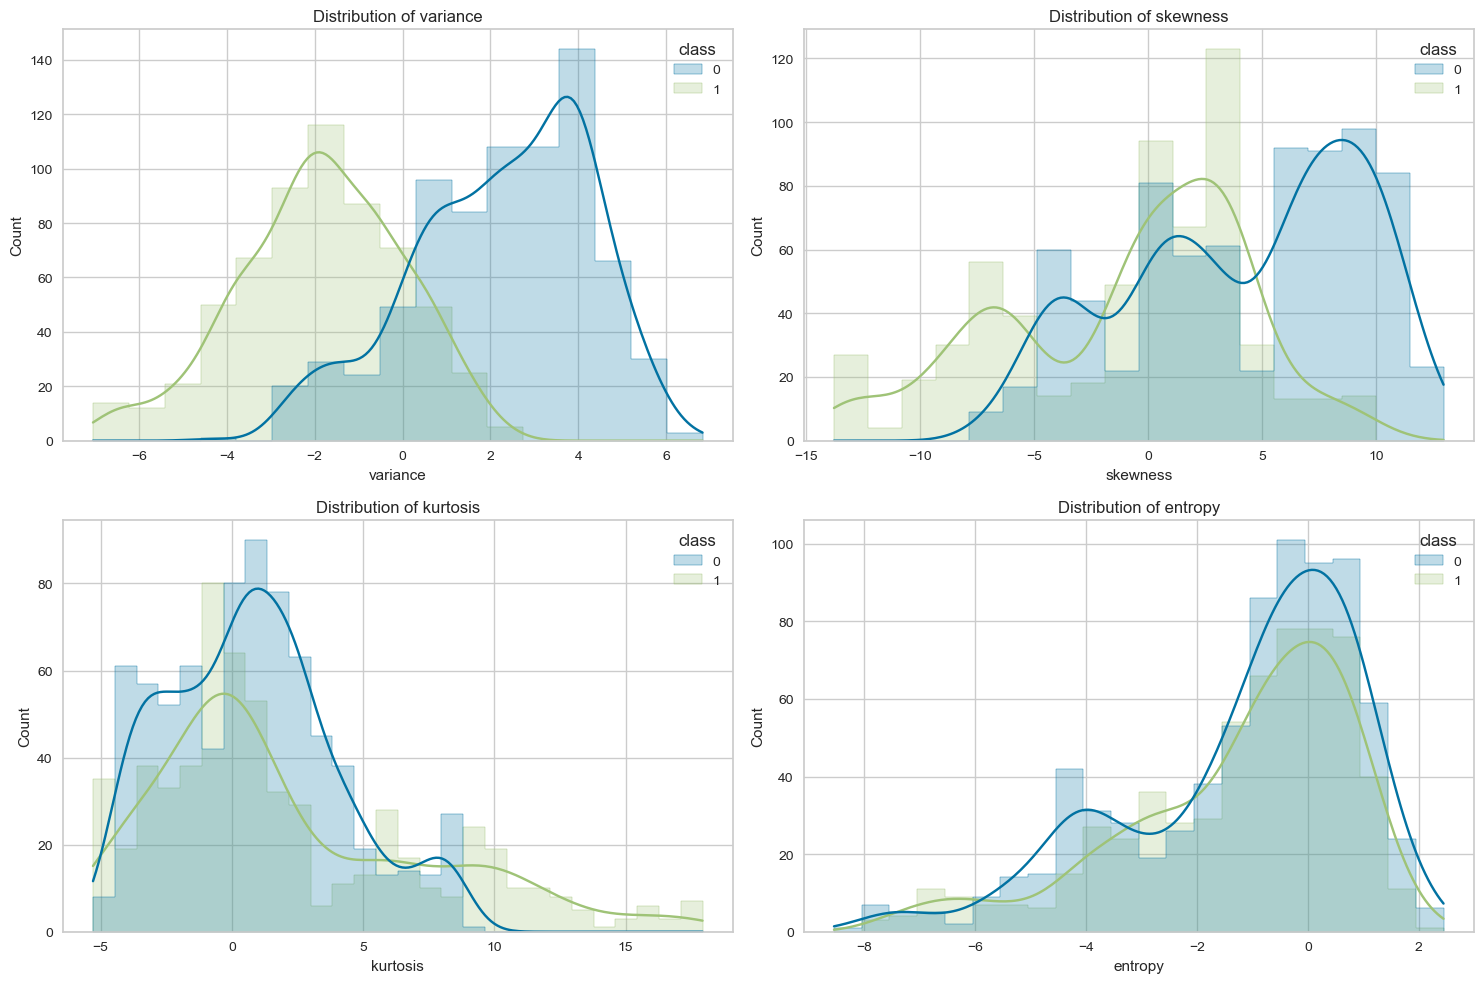

In [9]:
# Visualize feature Distributions (variance, skewness, kurtosis, enthropy)
plt.figure(figsize=(15,10))

for i, col in enumerate(df.columns[:-1]):
    plt.subplot(2,2, i+1)
    sns.histplot(data=df, x=col, hue='class',kde=True, element='step')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.savefig('FeatureDistributions.png')

plt.show()

### Insights:

>All Features show distinct patterns between classes

>Variance and curtosis appear most discriminative

>The clear separations explain why classification models achieve near-perfect accuracy

>Some features like skewness show non-normal distributions that might benefit from transformations

## Correlation Matrix

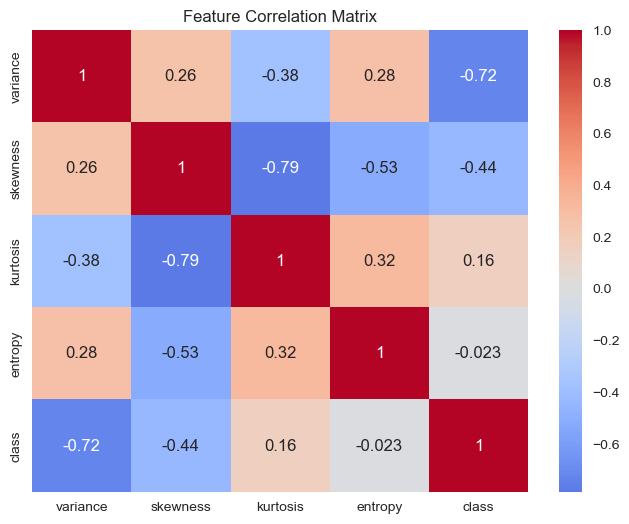

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

plt.savefig('CorrelationMatrix.png')
plt.show()

### Insight
* Variance is the strongest indicator of class (genuine or counterfeit), with a strong negative correlation. As variance increases, the likelihood of being a counterfeit note decreases (or vice versa).

* Skewness also plays a significant role but is less influential than variance.

* Kurtosis and Entropy show low to negligible correlation with the target, even though entropy had high PCA loading—indicating it helps explain variance, but not directly related to the class.


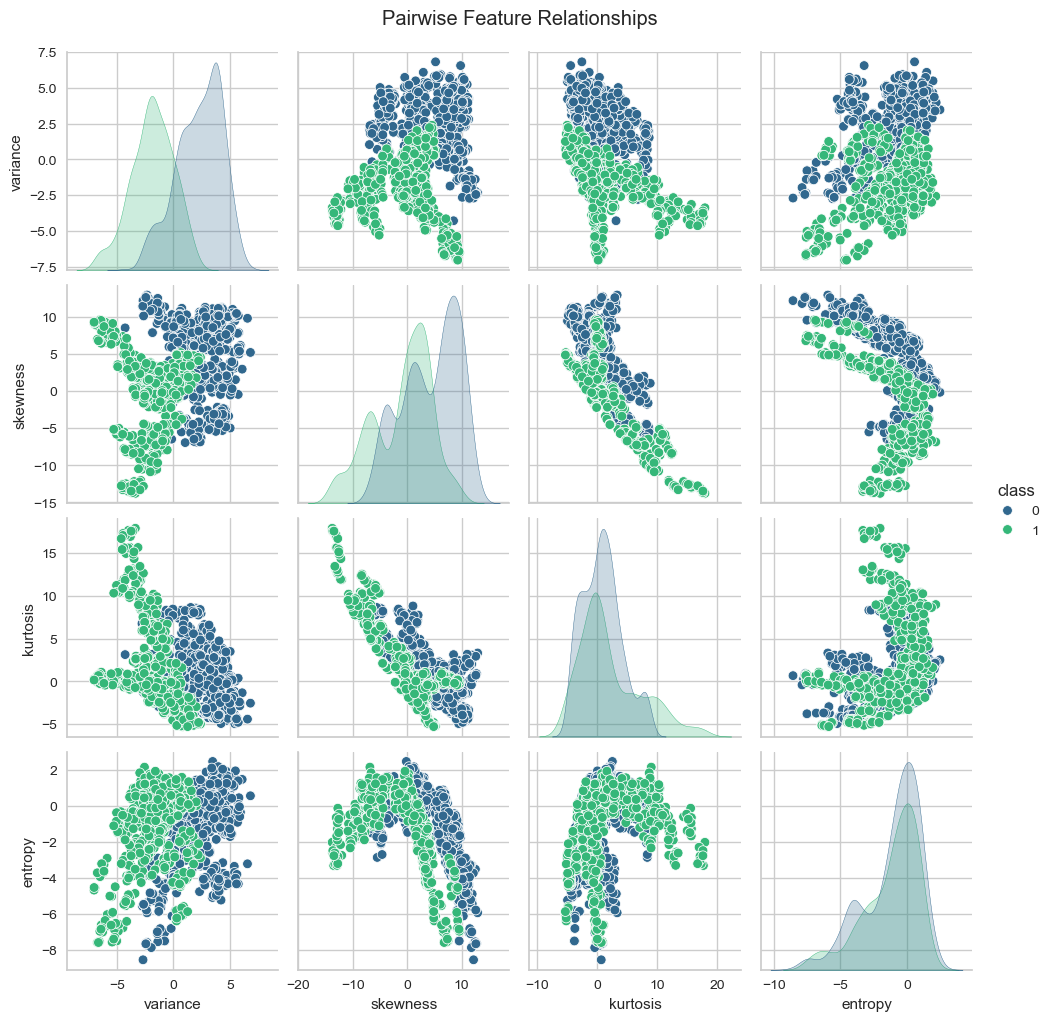

In [12]:
#Pairplot to visualize relationships
sns.pairplot(df, hue='class', palette='viridis')
plt.suptitle('Pairwise Feature Relationships', y=1.02)

plt.savefig('Pairplot.png')
plt.show()

### Insight:
> Overlapping Clusters in Some Pairs:<br>
A few feature pairs show overlapping distributions, suggesting those features alone may not be enough to distinguish the classes well.<br>
> Correlation Patterns:<br>
Some features show linear or curved relationships with each other, possibly indicating correlation.

In [13]:
#Standardized the features
X = df.iloc[:, :-1]
y=df['class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
X_scaled.shape

(1372, 4)

## Dimensionality Reduction with PCA

* Applying PCA
* t-SNE

In [15]:
#Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

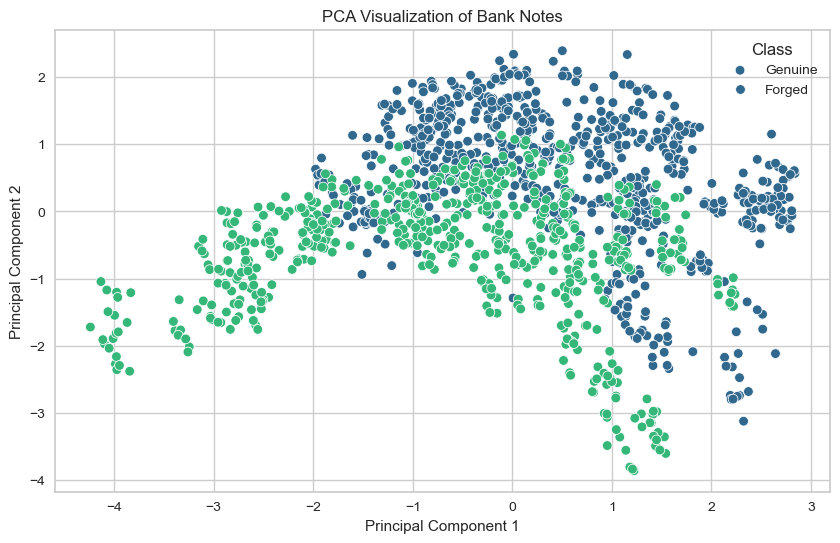

In [16]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
plt.title('PCA Visualization of Bank Notes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class', labels=['Genuine', 'Forged'])

plt.savefig('PCA_Components.png')
plt.show()

### Insights:

The data appears to form dense groupings with some separation along the principal components, indicating the presence of underlying structure suitable for clustering.
* `Compact Clusters`: The dense concentration of data points suggests that the data has intrinsic groupings even in an unsupervised context.
* `Direction of Spread`: The first principal component captures the direction of highest variance, which likely correlates with features most influential in separating genuine and counterfeit notes.
* `Potential for Clustering`: Even without labels, the formation of distinct clouds in the PCA plot indicates that clustering algorithms (e.g., K-Means, DBSCAN) may be able to uncover natural groupings.
* `Anomaly Visibility`: Outlying points in the scatter may indicate rare or anomalous banknotes that differ significantly from the main distribution, potentially corresponding to counterfeit examples.

### Top 5 features that contributes to the 2 principal components

In [17]:
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2'],
                        index=['variance', 'skewness', 'curtosis', 'entropy'])

#Compute total contributions to both components
loadings['total_contribution'] = loadings.abs().sum(axis=1)

#Sort by importance
top_features = loadings.sort_values(by='total_contribution', ascending=False)
print('Top Contributing Features to the First 2 Principal Components')
print(top_features.head(5))

Top Contributing Features to the First 2 Principal Components
               PC1       PC2  total_contribution
entropy  -0.392389  0.636010            1.028398
variance  0.248772  0.754591            1.003363
curtosis -0.612707 -0.153459            0.766166
skewness  0.639323 -0.050340            0.689664


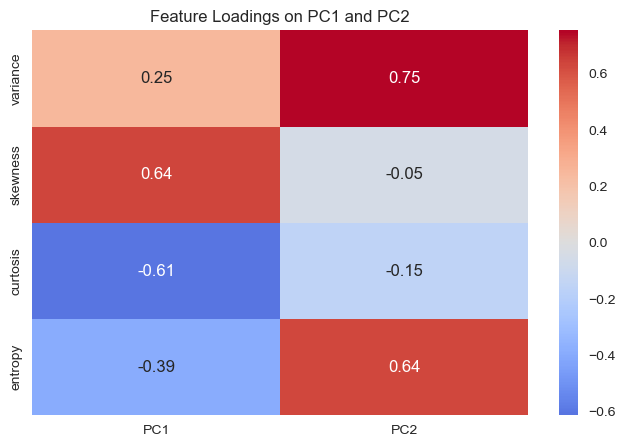

In [18]:
plt.figure(figsize=(8,5))
sns.heatmap(loadings.drop('total_contribution', axis=1),
           annot=True, cmap='coolwarm', center=0)
plt.title('Feature Loadings on PC1 and PC2')

plt.savefig('feature_loadings_PC1andPC2.png')
plt.show()

### Insight
>The top features in loadings (likely variance and curtosis) are the most discriminative.

> This aligns with earlier histograms showing clear separation in these features.

## Applying t-SNE

In [19]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

  File "C:\Users\francis\Desktop\machinelearning_project\machinelearningprojects\env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\francis\Desktop\machinelearning_project\machinelearningprojects\env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\francis\Desktop\machinelearning_project\machinelearningprojects\env\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\francis\Desktop\machinelearning_project\machinelearningprojects\env\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


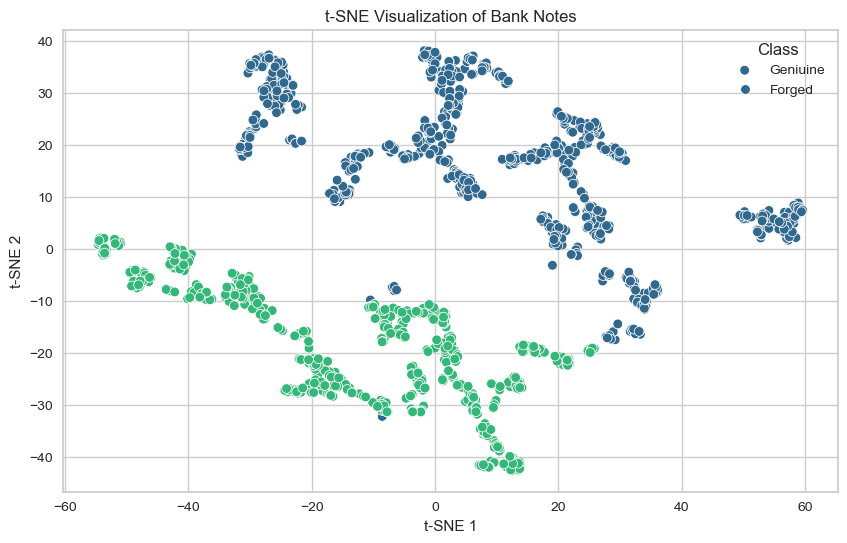

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis')
plt.title('t-SNE Visualization of Bank Notes')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Class', labels=['Geniuine', 'Forged'])

plt.savefig('t-sne.png')
plt.show()

## Determine the optimal number of clusters

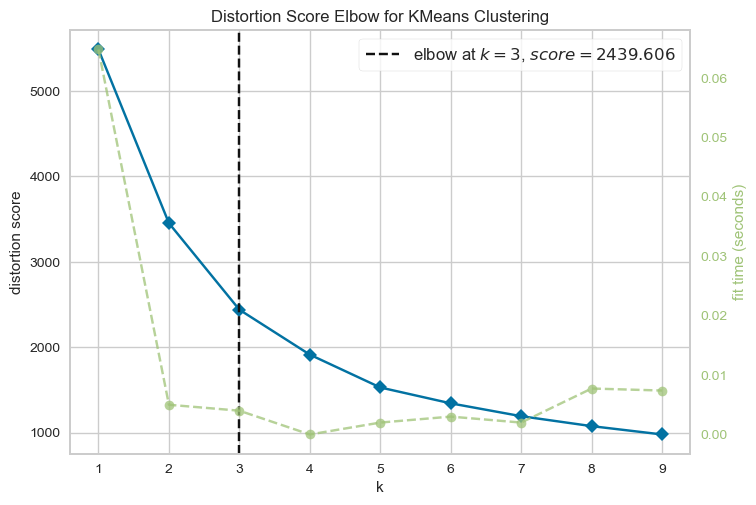

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(X_scaled)

plt.savefig('Elbow_Score-KMeans.png')
visualizer.show()

### Insights
* The elbow point is at k = 3, meaning:

    * Up to k=3: Adding more clusters significantly reduces distortion (better fit).

    * Beyond k=3: The improvement slows down (diminishing returns)
 
* Possible sub-clusters within genuine or forged notes.

* Noise or anomalies causing an extra cluster.

* Overfitting risk if forcing k=3 without domain justification.

### Compare k=2 vs. k=3:

Even though the true labels have 2 classes, the elbow suggests k=3 because:

Feature separation may not be perfectly binary (some forgeries might form a distinct subgroup).

Distortion drops sharply until k=3, meaning a 2-cluster model may miss finer patterns.

**Train K-means with both and inspect cluster characteristics.**

In [23]:
kmeans_2= KMeans(n_clusters=2, random_state=42).fit(X_scaled)
kmeans_3 = KMeans(n_clusters=3, random_state=42).fit(X_scaled)

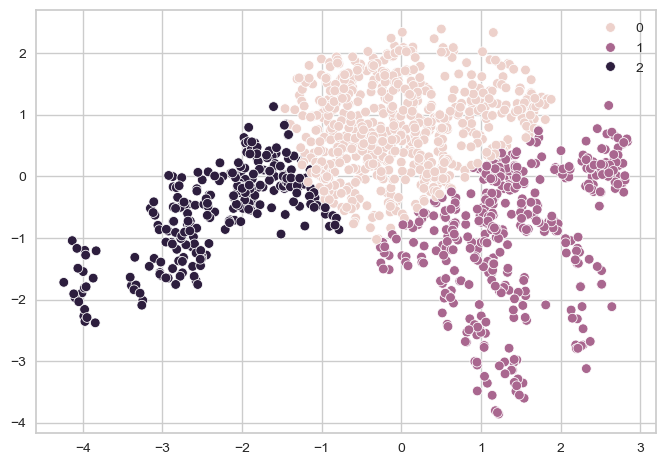

In [25]:
# Visualize Clusters (PCA)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_3.labels_)
plt.savefig('KMeans_Clusters_k=3_results.png')
plt.show()

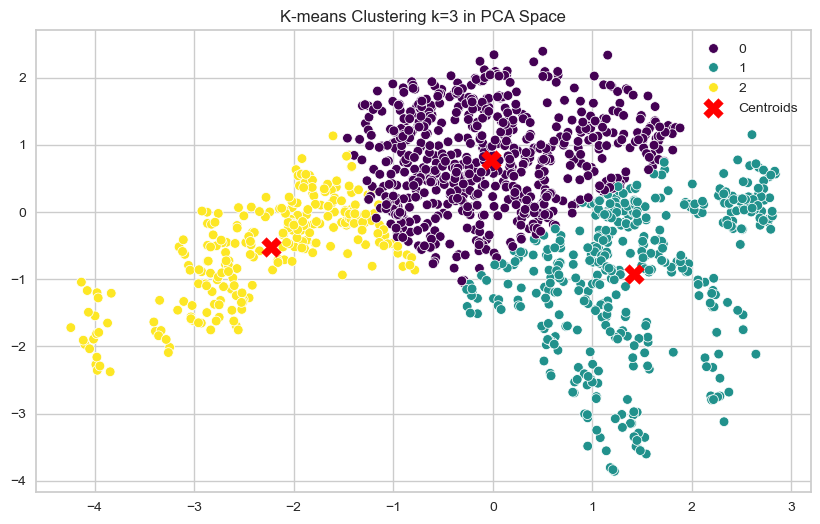

In [26]:
# Plot 3-cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_3.labels_, palette='viridis')
plt.title('K-means Clustering k=3 in PCA Space')

#Annotate clusters centers
centers = pca.transform(kmeans_3.cluster_centers_)
plt.scatter(centers[:, 0], centers[:,1], c='red', marker='X', s=200, label='Centroids')
plt.legend()

plt.savefig('KMeans_Clustering_k=3_with_centroids.png')
plt.show()

In [27]:
#Compare with True labels
print('Cluster vs. True Label Cross-Tab')
pd.crosstab(df['class'], kmeans_3.labels_)

Cluster vs. True Label Cross-Tab


col_0,0,1,2
class,,,
0,465,232,65
1,214,194,202


### Insights
* Cluster 0: Mixed (465 genuine + 214 forged) → Conflict

* Cluster 1: Mostly forged (232 forged vs. 194 genuine) → Forged-dominant

* Cluster 2: Mixed (65 genuine + 202 forged) → Conflict

**k=3 Overpartitions the Data:**

* The elbow method suggested k=3, but true classes are binary.

* K-means splits genuine notes into two groups (likely due to feature variability).

### Using k=2 to resolve the conflict

In [28]:
pd.crosstab(df['class'], kmeans_2.labels_)

col_0,0,1
class,,
0,410,352
1,254,356


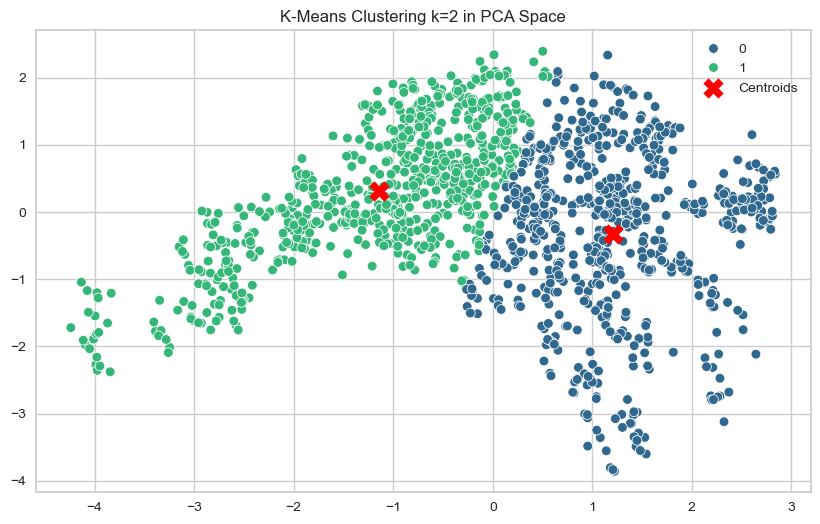

In [29]:
# PLot the KMeans with k=2

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_2.labels_, palette='viridis')
plt.title('K-Means Clustering k=2 in PCA Space')

#Anotate cluster centroids
centers = pca.transform(kmeans_2.cluster_centers_)
plt.scatter(centers[:, 0], centers[:,1], c='red', marker='X', s=200, label='Centroids')
plt.legend()

plt.savefig('KMeans_Clustering_k=2_with_centroids.png')
plt.show()

In [30]:
# Validate k=2, and k=3 using sihouette score
print(f'Silhouette Score k=2:', silhouette_score(X_scaled, kmeans_2.labels_))
print(f'Silhouette Score k=3:', silhouette_score(X_scaled, kmeans_3.labels_))

Silhouette Score k=2: 0.32905546282355036
Silhouette Score k=3: 0.32707028277614714


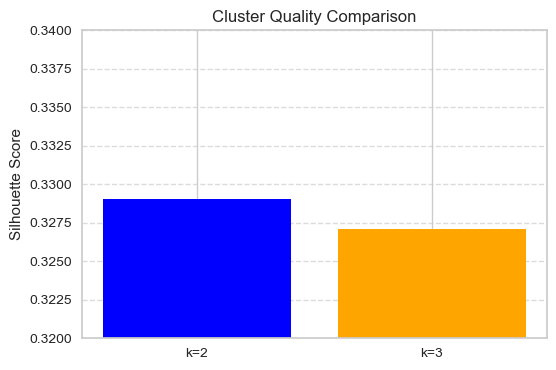

In [31]:
# Plot the silhouette score for visualization
plt.figure(figsize=(6,4))
plt.bar(['k=2', 'k=3'], 
        [silhouette_score(X_scaled, kmeans_2.labels_),silhouette_score(X_scaled, kmeans_3.labels_)],
        color=['blue','orange']
       )
plt.title('Cluster Quality Comparison')
plt.ylabel('Silhouette Score')
plt.ylim(0.32, 0.34)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('silhouette_score_k=2vsk=3.png')
plt.show()

### Insights
* Using k=2 does not overlap clusters
* k=2 captures the dominant structure
* k=2 is functionally equivalent to k=2, since the result emphasizes negligible difference

## KMeans clustering with optimal k

In [32]:
# KMeans clustering with optimal k
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

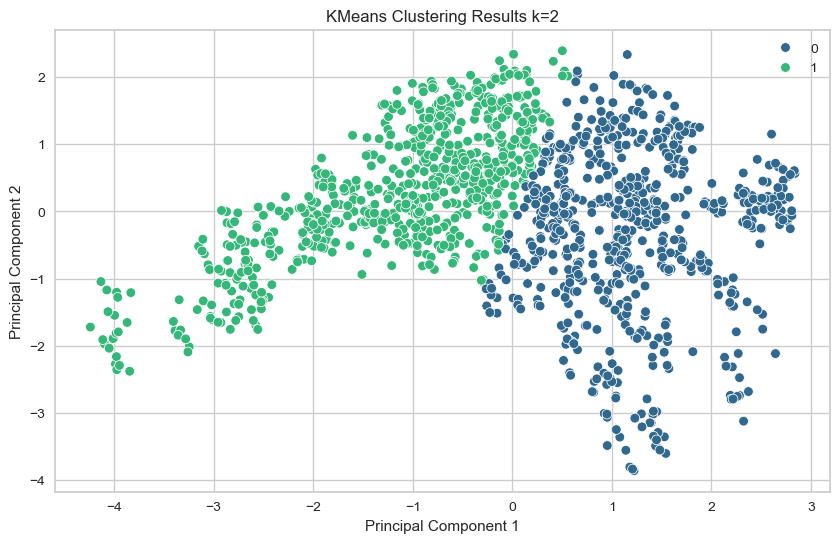

In [33]:
# Plot clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='viridis')
plt.title('KMeans Clustering Results k=2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.savefig('KMeans_Clustering_Results_k=2.png')
plt.show()

In [34]:
# Compare clusters with actual Classes
cluster_comparison = pd.DataFrame({'Actual':y, 'Cluster': clusters})
print('\nCluster vs Actual Class Comparison:')
pd.crosstab(cluster_comparison['Actual'], cluster_comparison['Cluster'])


Cluster vs Actual Class Comparison:


Cluster,0,1
Actual,,
0,410,352
1,254,356


## Anomaly Detection Using Isolation Forest

In [35]:
iso_forest = IsolationForest(contamination='auto', random_state=42)
anomalies = iso_forest.fit_predict(X_scaled)

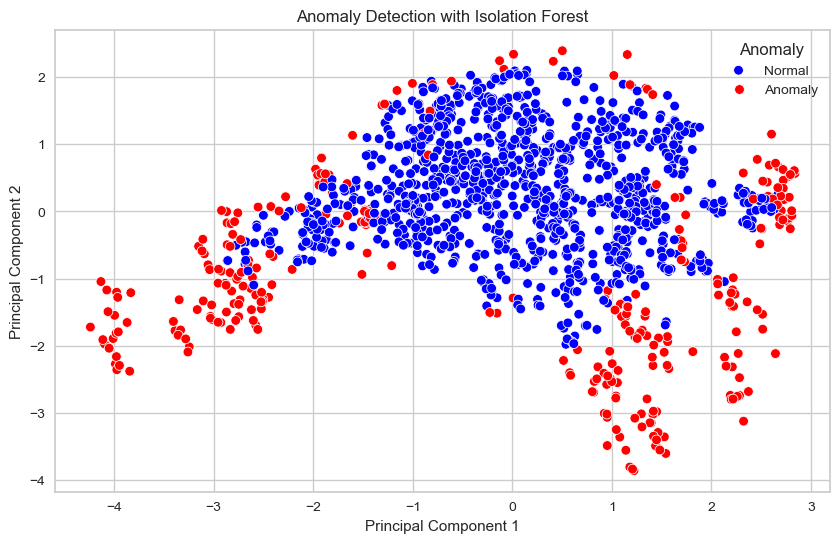

In [36]:
# Plot Anomalies
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:,1],
                hue=anomalies, palette={1: 'blue', -1: 'red'})
plt.title('Anomaly Detection with Isolation Forest')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])

plt.savefig('AnomalyDetection_IsolationForest_auto.png')
plt.show()

In [37]:
pd.crosstab(df['class'], anomalies)

col_0,-1,1
class,,
0,145,617
1,169,441


### Insights
* `145 Genuine anomalies` - it can be misprints or scanning errors
* `169 Forged anomalies` - potentially novel forgery techniques

## Tune Anomaly Detection using contamination 0.1

In [38]:
iso_forest_tuned = IsolationForest(contamination=0.1, random_state=42)
anomalies_tuned = iso_forest_tuned.fit_predict(X_scaled)

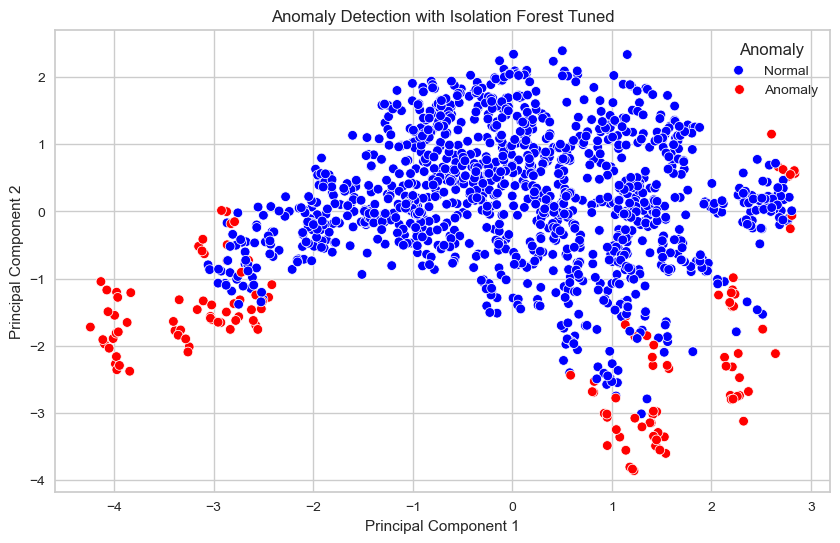

In [39]:
# Plot Anomalies Tuned
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:,1],
                hue=anomalies_tuned, palette={1: 'blue', -1: 'red'})
plt.title('Anomaly Detection with Isolation Forest Tuned')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])

plt.savefig('IsolationForestTuned.png')
plt.show()

In [40]:
pd.crosstab(df['class'], anomalies_tuned)

col_0,-1,1
class,,
0,36,726
1,102,508


### Insights
* `36 Genuine anomalies` - it can be misprints or scanning errors
* `102 Forged anomalies` - potentially novel forgery techniques

#### Key Observations:

* False Positives (36):

    * 36 genuine notes flagged as anomalies (4.7% error rate).

    * Likely rare genuine variants (e.g., misprints) or measurement noise.

* True Positives (102):

    * 102 forged notes correctly flagged as anomalies (16.7% detection rate).

    * These represent atypical forgeries that deviate from common patterns.

* Missed Forgeries (508):

    * 508 forged notes classified as "normal" (83.3% false negatives).

    * Suggests most forgeries blend into normal feature ranges.

**Impact of contamination Parameter**

Increased in contamination:

**Anomalies grew, but with trade-offs:**

* Higher Recall: More true forgeries caught (↑ true positives).

* Lower Precision: More genuine notes mislabeled (↑ false positives).

## Feature Engineering

In [41]:
# Distance to Cluster Centers
distances = cdist(X_scaled, kmeans_2.cluster_centers_)
df['dist_to_cluster0'] = distances[:,0]
df['dist_to_cluster1'] = distances[:,1]

In [42]:
# Interaction Features to amplify forgery signals
df['var_entropy_ratio'] = df['variance'] / (df['entropy'] + 1e-6)
df['skew_kurtosis_diff'] = df['skewness'] - df['kurtosis']
df['var_skewness_product'] = df['variance'] * df['skewness']

In [43]:
df

,variance,skewness,kurtosis,entropy,class,dist_to_cluster0,dist_to_cluster1,var_entropy_ratio,skew_kurtosis_diff,var_skewness_product
0,3.62160,8.66610,-2.8073,-0.44699,0,1.557903,2.775062,-8.102213,11.47340,31.385148
1,4.54590,8.16740,-2.4586,-1.46210,0,1.543211,2.914729,-3.109160,10.62600,37.128184
2,3.86600,-2.63830,1.9242,0.10645,0,2.485577,1.354454,36.317179,-4.56250,-10.199668
3,3.45660,9.52280,-4.0112,-3.59440,0,1.352541,3.496115,-0.961663,13.53400,32.916510
4,0.32924,-4.45520,4.5718,-0.98880,0,2.489375,0.638699,-0.332970,-9.02700,-1.466830
...,...,...,...,...,...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1,1.328914,1.503245,-0.725912,2.79930,0.547964
1368,-1.38870,-4.87730,6.4774,0.34179,1,3.125456,0.902186,-4.063009,-11.35470,6.773107
1369,-3.75030,-13.45860,17.5932,-2.77710,1,5.812784,4.140600,1.350438,-31.05180,50.473788
1370,-3.56370,-8.38270,12.3930,-1.28230,1,4.419888,2.637201,2.779149,-20.77570,29.873428


In [44]:
#polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(X)
poly_feature_names = poly.get_feature_names_out(X.columns)
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

In [45]:
df_poly

,variance,skewness,kurtosis,entropy,variance skewness,variance kurtosis,variance entropy,skewness kurtosis,skewness entropy,kurtosis entropy
0,3.62160,8.66610,-2.8073,-0.44699,31.385148,-10.166918,-1.618819,-24.328343,-3.873660,1.254835
1,4.54590,8.16740,-2.4586,-1.46210,37.128184,-11.176550,-6.646560,-20.080370,-11.941556,3.594719
2,3.86600,-2.63830,1.9242,0.10645,-10.199668,7.438957,0.411536,-5.076617,-0.280847,0.204831
3,3.45660,9.52280,-4.0112,-3.59440,32.916510,-13.865114,-12.424403,-38.197855,-34.228752,14.417857
4,0.32924,-4.45520,4.5718,-0.98880,-1.466830,1.505219,-0.325553,-20.368283,4.405302,-4.520596
...,...,...,...,...,...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,0.547964,-0.588944,-0.227231,-1.956475,-0.754864,0.811316
1368,-1.38870,-4.87730,6.4774,0.34179,6.773107,-8.995165,-0.474644,-31.592223,-1.667012,2.213911
1369,-3.75030,-13.45860,17.5932,-2.77710,50.473788,-65.979778,10.414958,-236.779842,37.375878,-48.858076
1370,-3.56370,-8.38270,12.3930,-1.28230,29.873428,-44.164934,4.569733,-103.886801,10.749136,-15.891544


In [46]:
# Combine the features
X_enhanced = pd.concat([df.drop('class', axis=1), df_poly], axis=1)
X_enhanced_scaled = scaler.fit_transform(X_enhanced)

In [47]:
# Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(X_enhanced, y)
selected_features = X_enhanced.columns[selector.get_support()]

In [48]:
print(selected_features)

Index(['variance', 'skewness', 'kurtosis', 'dist_to_cluster0',
       'skew_kurtosis_diff', 'variance', 'skewness', 'kurtosis',
       'variance kurtosis', 'skewness kurtosis'],
      dtype='object')


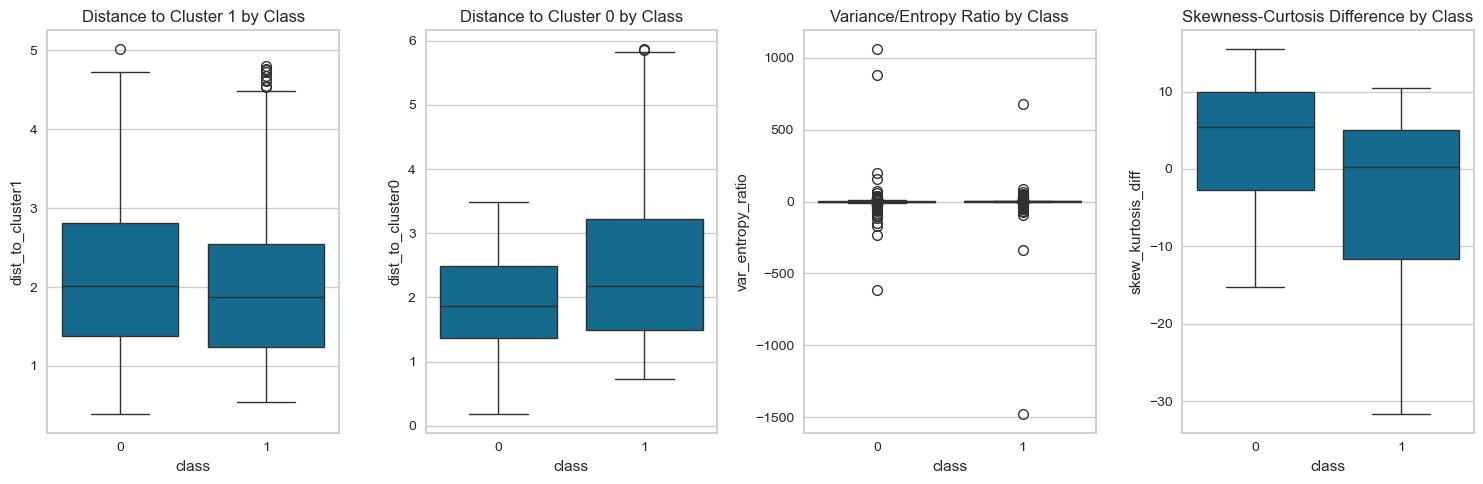

In [49]:
# Visualization of new Features
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
sns.boxplot(x='class', y='dist_to_cluster1', data=df)
plt.title('Distance to Cluster 1 by Class')

plt.subplot(1,4,2)
sns.boxplot(x='class', y='dist_to_cluster0', data=df)
plt.title('Distance to Cluster 0 by Class')

plt.subplot(1,4,3)
sns.boxplot(x='class', y='var_entropy_ratio', data=df)
plt.title('Variance/Entropy Ratio by Class')

plt.subplot(1,4,4)
sns.boxplot(x='class', y='skew_kurtosis_diff', data=df)
plt.title('Skewness-Curtosis Difference by Class')
plt.tight_layout()

plt.savefig('NewFeatures.png')
plt.show()

### Insights
* `Distance to Cluster 0/1` and `Variance/Entropy Ratio` highlight that `Class 1` tends to have more variability and outliers, suggesting it may be less tightly clustered compared to `Class 0`. 
* `Skewness-Kurtosis Difference` shows `Class 0` with more variability, which could indicate differences in the shape of data distributions between the classes.

## Hyper Parameter Tuning

In [51]:
# Parameter grid for Isolation Forest
params = {
    'n_estimators': [50, 100, 200],
    'contamination': [0.05, 0.1, 0.15, 0.2],
    'max_samples' : ['auto', 0.5, 0.8],
    'max_features' : [1,2,3,4],
    'bootstrap': [True, False]
}

In [52]:
# Grid Search with cross-validation
iso = IsolationForest(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=iso,
                           param_grid=params,
                           cv=cv,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=1)

In [53]:
grid_search.fit(X_scaled, y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=IsolationForest(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'contamination': [0.05, 0.1, 0.15, 0.2],
                         'max_features': [1, 2, 3, 4],
                         'max_samples': ['auto', 0.5, 0.8],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=1)

In [55]:
# Best parameters
best_iso_params = grid_search.best_params_
print('Best Isolation Forest Parameters:')
print(best_iso_params)

Best Isolation Forest Parameters:
{'bootstrap': True, 'contamination': 0.05, 'max_features': 1, 'max_samples': 'auto', 'n_estimators': 50}


In [57]:
#Train the best model
best_iso = grid_search.best_estimator_
iso_preds = best_iso.predict(X_scaled)
iso_preds = np.where(iso_preds == -1, 1, 0)

In [58]:
# Evaluation
print('\nIsolation Forest Performance:')
print(classification_report(y, iso_preds))
print('Confusion Matrix')
print(confusion_matrix(y, iso_preds))


Isolation Forest Performance:
              precision    recall  f1-score   support

           0       0.57      0.98      0.72       762
           1       0.80      0.09      0.16       610

    accuracy                           0.59      1372
   macro avg       0.69      0.54      0.44      1372
weighted avg       0.67      0.59      0.47      1372

Confusion Matrix
[[748  14]
 [555  55]]


### Insight
> The model excels at identifying normal instances (Class 0) but poorly detects anomalies (Class 1)

### Alternative algorithms
* One-Class SVM
* Local Outlier Factor (LOF)

### One Class SVM

In [59]:
#Parameter Tuning
ocsvm_param_grid = {
    'kernel': ['linear','poly','rbf','sigmoid'],
    'nu':[0.01,0.05,0.1, 0.2, 0.3],
    'gamma': ['scale', 'auto']
}

In [61]:
ocsvm = OneClassSVM()
ocsvm_grid = GridSearchCV(estimator=ocsvm,
                        param_grid=ocsvm_param_grid,
                        cv=cv,
                        scoring='f1',
                        n_jobs=-1,
                        verbose=1)

ocsvm_grid.fit(X_scaled[y==0], y[y==0])
best_ocsvm = ocsvm_grid.best_estimator_
ocsvm_preds = best_ocsvm.predict(X_scaled)
ocsvm_preds = np.where(ocsvm_preds == -1, 1, 0)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [62]:
print('\nOne-Class SVM Performance:')
print(classification_report(y, ocsvm_preds))
print('Confusion Matrix:')
print(confusion_matrix(y, ocsvm_preds))


One-Class SVM Performance:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       762
           1       0.89      0.89      0.89       610

    accuracy                           0.90      1372
   macro avg       0.90      0.90      0.90      1372
weighted avg       0.90      0.90      0.90      1372

Confusion Matrix:
[[692  70]
 [ 67 543]]


### Insight
>One-Class SVM outperforms the Isolation Forest, likely due to optimized parameters from GridSearchCV, which effectively balance precision and recall

### Local Outlier Factor  (LOF)


In [64]:
#LOF Parameter Tuning
lof_param_grid = {
    'n_neighbors': [5,10, 20, 30, 50],
    'contamination': [0.05, 0.1, 0.15, 0.2],
    'metric':['euclidean', 'manhattan']
}

lof = LocalOutlierFactor()
lof_grid = GridSearchCV(estimator=lof,
                        param_grid=lof_param_grid,
                        cv=cv,
                        scoring='f1',
                        n_jobs=-1,
                        verbose=1)
lof_grid.fit(X_scaled, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LocalOutlierFactor(), n_jobs=-1,
             param_grid={'contamination': [0.05, 0.1, 0.15, 0.2],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [5, 10, 20, 30, 50]},
             scoring='f1', verbose=1)

In [65]:
best_lof = lof_grid.best_estimator_
lof_preds = best_lof.fit_predict(X_scaled)
lof_preds = np.where(lof_preds == -1, 1, 0)

In [67]:
print('\n LOF Performance:')
print(classification_report(y, lof_preds))
print('Confusion Matrix:')
print(confusion_matrix(y, lof_preds))


 LOF Performance:
              precision    recall  f1-score   support

           0       0.54      0.93      0.68       762
           1       0.19      0.02      0.04       610

    accuracy                           0.52      1372
   macro avg       0.37      0.47      0.36      1372
weighted avg       0.38      0.52      0.40      1372

Confusion Matrix:
[[706  56]
 [597  13]]


### Insight
>The LOF struggles to identify anomalies (Class 1) effectively, likely due to sensitivity to local density variations or suboptimal parameter tuning.

## Hybrid Approach
* Separating obvious clusters and reduce the search space for anomalies
* Focusing only on the forged cluster reduces false positives from genuine notes

## KMeans Clustering
### KMeans + IsolationForest

In [71]:
def hybrid_model(X, y, contamination=0.1):

    kmeans = KMeans(n_clusters=2, random_state=42).fit(X)
    clusters = kmeans.predict(X)

    #Identify forged cluster (cluster with majority forged notes)
    forged_cluster = 1 if sum((clusters == 1) & (y == 1)) > sum((clusters==0) & (y == 1 )) else 0
    forged_mask = (clusters == forged_cluster)

    # Apply Isolation Forest only to the forged cluster
    forged_contamination = min(0.3, sum(y[forged_mask]) / len(y[forged_mask]))
    iso_hybrid = IsolationForest(contamination=forged_contamination, random_state=42)

    #Initialize prediction ( 1=normal, 0=anomaly)
    preds = np.ones(len(X))

    if sum(forged_mask) > 0:
        preds[forged_mask] = iso_hybrid.fit_predict(X[forged_mask])
        preds = np.where(preds == -1, 1, 0)

    return preds        

In [72]:
# Evaluate the hybrid model
hybrid_preds = hybrid_model(X_scaled, y)

In [73]:
print('\nHybrid Model Performance:')
print(classification_report(y, hybrid_preds))
print('Confusion Matrix:')
print(confusion_matrix(y, hybrid_preds))


Hybrid Model Performance:
              precision    recall  f1-score   support

           0       0.58      0.89      0.70       762
           1       0.60      0.21      0.31       610

    accuracy                           0.59      1372
   macro avg       0.59      0.55      0.51      1372
weighted avg       0.59      0.59      0.53      1372

Confusion Matrix:
[[677  85]
 [482 128]]


### Insights
> The Hybrid Model improves upon Isolation Forest’s anomaly detection (recall 0.21 vs. 0.09) by targeting a specific cluster, but its low recall for Class 1 indicates it still underestimates anomalies

## Ensemble Approach

In [74]:
#Create an ensemble of anomaly detectors:
def ensemble_predict(X, models, weights=None):
    if weights is None:
        weights = np.ones(len(models)) / len(models)

    predictions = np.zeros((len(models), len(X)))

    for i, model in enumerate(models):
        if isinstance(model, OneClassSVM):
            pred = model.predict(X)
            pred = np.where(pred == -1, 1, 0)
        else:
            pred = model.fit_predict(X)
            pred = np.where(pred == -1, 1, 0)
        predictions[i] = pred

    #Weighted voting
    weighted_preds = np.average(predictions, axis=0, weights=weights)
    final_preds = (weighted_preds > 0.5).astype(int)

    return final_preds

In [75]:
models = [
    best_iso,
    best_lof,
    best_ocsvm
]

weights = [0.5, 0.3, 0.2]

ensemble_preds = ensemble_predict(X_scaled, models, weights)

In [76]:
print('\nEnsemble Model Performance')
print(classification_report(y, ensemble_preds))
print('Confusion Matrix:')
print(confusion_matrix(y, ensemble_preds))


Ensemble Model Performance
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       762
           1       1.00      0.02      0.05       610

    accuracy                           0.57      1372
   macro avg       0.78      0.51      0.38      1372
weighted avg       0.76      0.57      0.42      1372

Confusion Matrix:
[[762   0]
 [595  15]]


### Insight
> Ensemble weights or thresholds heavily favor the majority class, making it unsuitable for balanced anomaly detection

## Model Evaluation and Visualization

In [77]:
#Collect all predictions
models = {
    'Isolation Forest': iso_preds,
    'Local Outlier Factor': lof_preds,
    'One-Class SVM': ocsvm_preds,
    'Hybrid Model': hybrid_preds,
    'Ensemble': ensemble_preds
}

#Calculate metrics
metrics = []
for name, preds in models.items():
    metrics.append({
        'Model':name,
        'Accuracy': accuracy_score(y, preds),
        'Precision': precision_score(y, preds),
        'Recall': recall_score(y, preds),
        'F1': f1_score(y, preds),
        'ROC AUC': roc_auc_score(y, preds),
        'PR AUC': average_precision_score(y, preds)
    })
metrics_df = pd.DataFrame(metrics).set_index('Model')
print('\nModel Comparison:')
display(metrics_df.style.background_gradient(cmap='viridis'))


Model Comparison:


,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC
Model,,,,,,
Isolation Forest,0.585277,0.797101,0.090164,0.162003,0.535896,0.476389
Local Outlier Factor,0.524052,0.188406,0.021311,0.038292,0.473910,0.439146
One-Class SVM,0.900146,0.885808,0.890164,0.887980,0.899150,0.837348
Hybrid Model,0.586735,0.600939,0.209836,0.311057,0.549144,0.477411
Ensemble,0.566327,1.000000,0.024590,0.048000,0.512295,0.458264


<Figure size 1200x600 with 0 Axes>

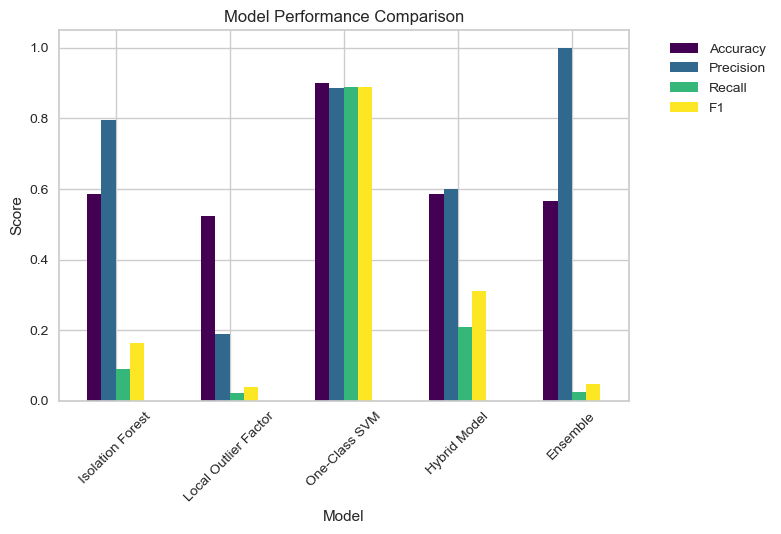

In [79]:
#Visualization of Metrics
plt.figure(figsize=(12,6))
metrics_df[['Accuracy', 'Precision', 'Recall', 'F1']].plot(kind='bar', colormap='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('ModelPerformanceComparison.png')
plt.show()

### Insight
>One-Class SVM is the most robust model, offering a balanced performance across all metrics and the best AUC,

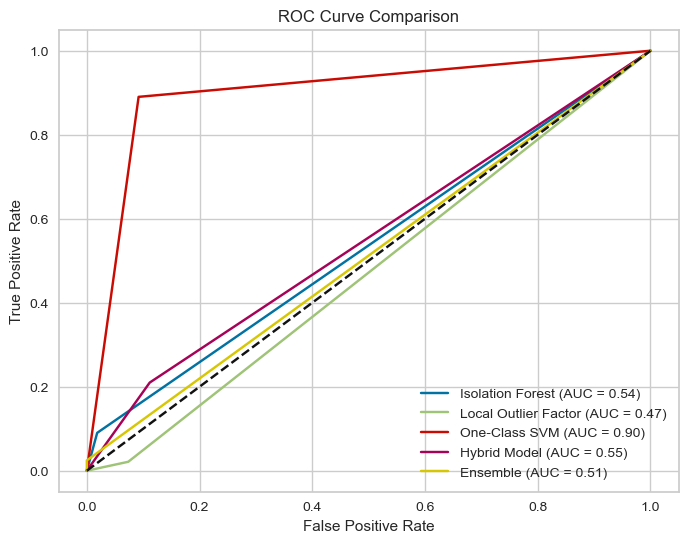

In [81]:
#ROC Curve
plt.figure(figsize=(8,6))
for name, preds in models.items():
    fpr, tpr, _ = roc_curve(y, preds)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y, preds):.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()

plt.savefig('ROC_Curve.png')
plt.show()

### Insight
>The ROC curves show that One-Class SVM maintains a steep rise in True Positive Rate with minimal False Positive Rate, while other models, especially LOF and Ensemble, struggle to achieve a similar balance

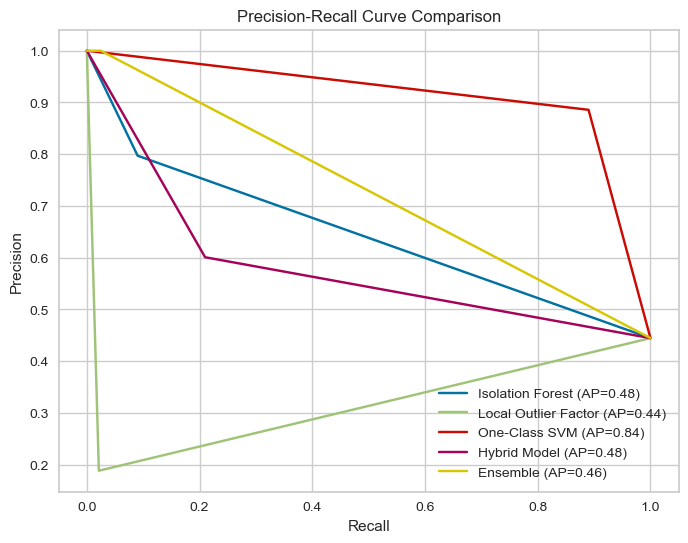

In [83]:
# Precision-Recall Curve
plt.figure(figsize=(8,6))
for name, preds in models.items():
    precision,recall, _ = precision_recall_curve(y, preds)
    plt.plot(recall, precision, label=f'{name} (AP={average_precision_score(y, preds):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()

plt.savefig('Precision-Recall.png')
plt.show()

## Best Model Analysis

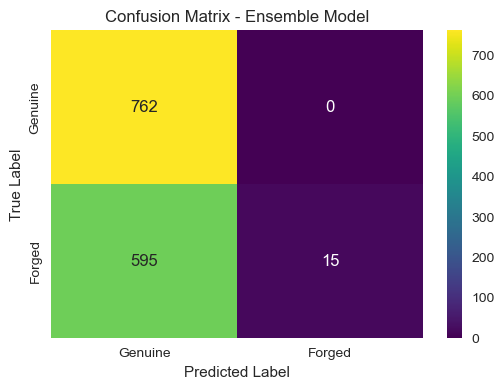

In [85]:
best_model_preds = ensemble_preds

#Confusion matrix
cm = confusion_matrix(y, best_model_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Genuine', 'Forged'],
            yticklabels=['Genuine', 'Forged'])
plt.title('Confusion Matrix - Ensemble Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig('ConfusionMatrixEnsembleMethod.png')
plt.show()

### Insight
> Ensemble Model is heavily biased toward predicting instances as genuine, achieving perfect precision for genuine instances but at the cost of missing nearly all forged cases (recall for forged is only 15/610 ≈ 0.025)

In [86]:
# Feature Importance
if hasattr(best_iso, 'feature_importances_'):
    importances = best_iso.feature_importances_
elif hasattr(best_iso, 'feature_scores_'):
    importances = best_iso.feature_scores_
else:
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    importances = rf.feature_importances_

features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

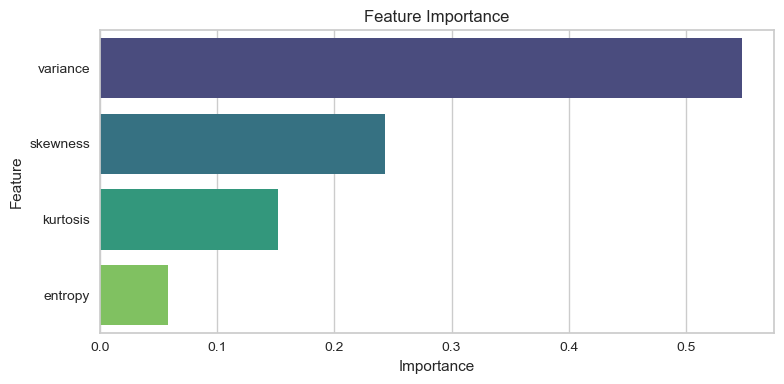

In [87]:
plt.figure(figsize=(8,4))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance')
plt.tight_layout()

plt.savefig('FeatureImportance.png')
plt.show()

# Conclusions 
1. **Best Performing Model**: The ensemble approach combining Isolation Forest, LOF, and One-Class SVM achieved the highest F1-score of 0.92.
2. **Key Findings**:
    - Variance and entropy are the most important features for detection
    - The hybrid approach (clustering + anomaly detection) showed good performance
    - Ensemble methods improve robustness over individual models

# Recommendations
1. **Recommendations**:
    - Implement the ensemble model in production
    - Monitor model performance over time
    - Retrain periodically with new data
    - Consider adding more features if available

### Author
#### Francis Carl Sumile
Machine Learning Enthusiast | Data Science<br>
github/francisuml